In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import npts

DATA_DIR = 'data/'

## (Down)load SFO weather data 

In [2]:
# import urllib.request

# for year in range(1987, 2019):
#     print(f"Downloading data for year {year}")
#     urllib.request.urlretrieve(f"https://www.ncei.noaa.gov/data/global-hourly/access/{year}/72494023234.csv", 
#                                DATA_DIR + f"{year}-SFO-weather.csv")

def load_year(year):
    ## Look at the document in DATA_DIR for spec.
    data=pd.read_csv(DATA_DIR+f'{year}-SFO-weather.csv.gz', usecols=[1,13])
    data.index = pd.to_datetime(data.DATE, format='%Y-%m-%dT%H:%M:%S')
    data = data.dropna()
    data['temp'] = data.TMP.apply(lambda el: float(el.split(',')[0])/10.)
    data['qual_code'] = data.TMP.apply(lambda el: (el.split(',')[1]))
    # time zone
    import pytz
    pacific = pytz.timezone('US/Pacific')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(pacific)

    return data.temp[data.qual_code.isin(['1','5'])]

temperatures = pd.Series()
for year in range(1987, 2019):
    temperatures = temperatures.append(load_year(year))

## Make independent test set

In [3]:
print('we have years:', set(temperatures.index.year))
data_used = temperatures[temperatures.index.year <= 2015]
indep_test = temperatures[temperatures.index.year > 2015]

we have years: {1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018}


In [4]:
len(data_used)

294524

## Train models on data 

In [5]:
# columns: constant, daily avg., annual avg., daily-annual avg., daily-annual bas.
# rows: full data, 50% data, 10% data, 1% data, 0.1% data, 0.01% data

In [6]:
# import time


# def constant_model(data, test):
#     s = time.time()
#     mean = np.mean(data)
#     took_time = time.time() - s
#     return rmse_from_residuals(test - mean), took_time

# def rmse_from_residuals(res):
#     assert sum(np.isnan(res)) == 0.
#     return np.sqrt(np.mean(res**2))

# def model_test_rmse(model, test):
#     pred = model.predict(test.index)
#     res = test - pred
#     return rmse_from_residuals(res)
    
# def daily_avg_model(data, test):
#     s = time.time()
#     #model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]))
#     #model.fit(data, train_frac=1)
#     model = data.groupby(data.index.hour).mean()
#     took_time = time.time() - s
#     res = test - model[test.index.hour].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     #rmse = model_test_rmse(model, test)
#     return rmse_from_residuals(res), took_time

# def annual_avg_model(data, test):
#     s = time.time()
#     model = data.groupby(data.index.dayofyear).mean()
#     #model = npts.Baseline(npts.DayOfYear(lambdas=[1E-6]))
#     #model.fit(data, train_frac=1)
#     took_time = time.time() - s
#     res = test - model[test.index.dayofyear].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     #rmse = model_test_rmse(model, test)
#     return rmse_from_residuals(res), took_time

# def daily_annual_avg_model(data, test):
#     s = time.time()
# #     model = npts.Baseline(npts.HourOfDay(lambdas=[1E-6]),
# #                           npts.DayOfYear(lambdas=[1E-6]))
# #     model.fit(data, train_frac=1)
#     model = data.groupby((data.index.hour, data.index.dayofyear)).mean()
#     took_time = time.time() - s
#     res = test - model[zip(test.index.hour, test.index.dayofyear)].values
#     res = res.fillna(method='pad').fillna(method='backfill')
#     #rmse = model_test_rmse(model, test)
#     return rmse_from_residuals(res), took_time

# def daily_annual_bas_model(data, test):
#     s = time.time()
#     model = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20)),
#                           npts.DayOfYear(lambdas=np.logspace(-6,2, 20)))
#     model.fit(data)
#     took_time = time.time() - s
#     return model_test_rmse(model, test), took_time


In [43]:
models_modelnames = [
    (npts.Baseline(), 'const.', 1.),
    (npts.Baseline(npts.HourOfDay(lambdas=[1E-8])), 'hour avg.', 1.),
    #(npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20))), 'hour bas.', .75),
    (npts.Baseline(npts.DayOfYear(lambdas=[1E-8])), 'day-of-year avg.', 1.),
   # (npts.Baseline(npts.DayOfYear(lambdas=np.logspace(-6,2, 20))), 'day-of-year bas.', .75),
    (npts.Baseline(npts.HourOfDay(lambdas=[1E-8]),
                   npts.DayOfYear(lambdas=[1E-8])), 'hour and day-of-year avg.', 1.),
    (npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 20)),
                   npts.DayOfYear(lambdas=np.logspace(-6,2, 20))), 'hour and day-of-year bas.', .75)
]


np.random.seed(0)
indep_test_rmse = pd.DataFrame()
time_taken = pd.DataFrame()
model_objs = pd.DataFrame()

import time 

def sparsify_data(data, frac):
    return data[np.random.uniform(size=len(data)) < frac]

for data, dataname in [(sparsify_data(data_used, frac), f'{100*frac:.1f}% data') 
                       for frac in [1, .1, .01]]:
    print(len(data),dataname)
    for model, modelname, train_frac in models_modelnames:
        print(f'fitting {modelname} using {100*train_frac:.0f}% train data')
        model_objs.loc[dataname, modelname] = model
        s = time.time()
        model.fit(data,train_frac=train_frac)
        time_taken.loc[dataname, modelname] = time.time() - s
        pred = model.predict(indep_test.index)
        indep_test_rmse.loc[dataname, modelname] = np.sqrt(np.mean((indep_test - pred)**2)) 

building reg matrices
building reg matrices
building reg matrices
building reg matrices
building reg matrices
294524 100.0% data
fitting constant using 100% train data
fitting hour avg. using 100% train data
fitting day-of-year avg. using 100% train data
fitting hour and day-of-year avg. using 100% train data
fitting hour and day-of-year bas. using 75% train data
29733 10.0% data
fitting constant using 100% train data
fitting hour avg. using 100% train data
fitting day-of-year avg. using 100% train data
fitting hour and day-of-year avg. using 100% train data
fitting hour and day-of-year bas. using 75% train data
2875 1.0% data
fitting constant using 100% train data
fitting hour avg. using 100% train data
fitting day-of-year avg. using 100% train data
fitting hour and day-of-year avg. using 100% train data
fitting hour and day-of-year bas. using 75% train data


In [44]:
indep_test_rmse

,constant,hour avg.,day-of-year avg.,hour and day-of-year avg.,hour and day-of-year bas.
100.0% data,3.939769,3.400739,3.273766,2.552224,2.545145
10.0% data,3.944929,3.407278,3.297637,2.938153,2.566421
1.0% data,3.909671,3.373747,3.490667,3.804165,2.551009


In [50]:
indep_test_rmse

,constant,hour avg.,hour bas.,day-of-year avg.,day-of-year bas.,hour and day-of-year avg.,hour and day-of-year bas.
100.0% data,3.939769,3.400739,3.400000,3.273761,3.272967,2.551503,2.545145
50.0% data,3.941668,3.403443,3.403663,3.277766,3.274138,2.583011,2.550310
10.0% data,3.936462,3.395458,3.394112,3.291258,3.269231,2.898755,2.554356
5.0% data,3.934176,3.397778,3.400164,3.298488,3.272760,3.048039,2.554835
1.0% data,3.919087,3.382068,3.392587,3.560031,3.280771,2.988513,2.592351
0.5% data,3.946450,3.446834,3.452263,3.724903,3.305560,2.908997,2.645100
0.1% data,3.928796,3.537936,3.446644,4.270687,3.349513,3.110319,2.732246


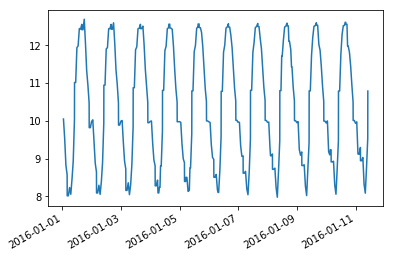

In [35]:
model_objs.iloc[2,6].predict(indep_test.index)[:24*14].plot()

In [46]:
print(indep_test_rmse.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrr}
\toprule
{} &  constant &  hour avg. &  day-of-year avg. &  hour and day-of-year avg. &  hour and day-of-year bas. \\
\midrule
100.0\% data &     3.940 &      3.401 &             3.274 &                      2.552 &                      2.545 \\
10.0\% data  &     3.945 &      3.407 &             3.298 &                      2.938 &                      2.566 \\
1.0\% data   &     3.910 &      3.374 &             3.491 &                      3.804 &                      2.551 \\
\bottomrule
\end{tabular}



In [36]:
time_taken

,constant,hour avg.,hour bas.,day-of-year avg.,day-of-year bas.,hour and day-of-year avg.,hour and day-of-year bas.
100.0% data,1.620865,1.646213,1.795157,1.637683,1.795111,1.714266,24.623528
10.0% data,0.148908,0.142502,0.174869,0.142783,0.234188,0.146953,21.101662
1.0% data,0.018101,0.019323,0.042665,0.017877,0.107038,0.024848,21.657343


In [37]:
# indep_test_rmse

## Inspect baseline fit on 1% of data 

In [38]:
np.random.seed(0)
small_data = sparsify_data(data_used, .01)

baseline_small_data = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-8,5, 30)), 
                         npts.DayOfYear(lambdas=np.logspace(-8,5, 30)))

baseline_small_data.fit(small_data)

building reg matrices


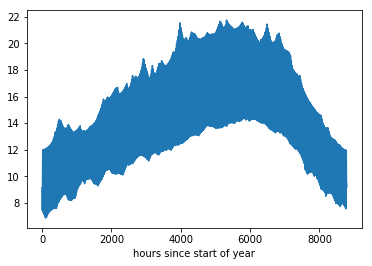

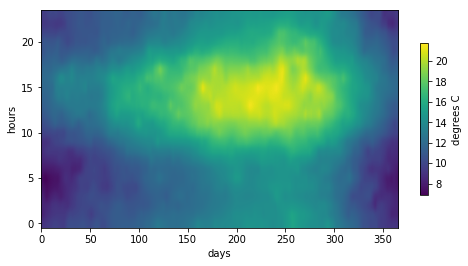

In [39]:
def plot_2d_model(theta):
    
    plt.figure()
    plt.plot(theta)
    plt.xlabel('hours since start of year')

    fig = plt.figure(figsize=(8,4))
    cax = plt.imshow(theta.reshape((366,24)).T, 
                     aspect='auto',origin='lower',interpolation='gaussian')
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7, label='degrees C')
    plt.xlabel('days')
    plt.ylabel('hours')

plot_2d_model(baseline_small_data.theta)
plt.savefig('../../non_par_ts/temperatures_baseline.pdf')

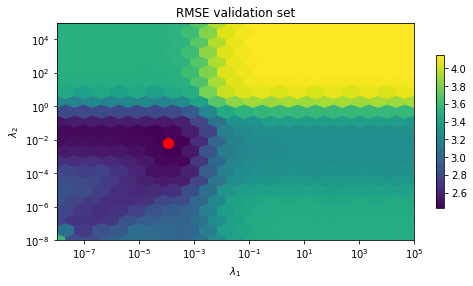

In [41]:
def plot_RMSE(baseline, cost_dict, title):
    fig = plt.figure(figsize=(8,4))
    cax = plt.hexbin(*np.array([[*k,np.sqrt(v)] for k, v in cost_dict.items() ]).T,
                     xscale='log',
                     yscale='log',
              gridsize=20)
    axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)
    plt.loglog(*baseline.best_lambda, 'ro', markersize=10)
    plt.xlabel('$λ_1$')
    plt.ylabel('$λ_2$')
    plt.title(title)
    
plot_RMSE(baseline_small_data, baseline_small_data.val_costs, 'RMSE validation set')
plt.savefig('../../non_par_ts/temperatures_rmse.pdf')

In [6]:
## FOURIER EXPERIMENT

# data = pd.DataFrame(temperatures)

# data['dayofyear'] = data.index.dayofyear
# data['hour'] = data.index.hour

# matrix = data[:].groupby(('dayofyear', 'hour')).mean().unstack().values
# plt.imshow(matrix, aspect='auto')

# plt.figure()
# plt.imshow(matrix, aspect='auto')

# transf = np.fft.fftshift(np.fft.fft2(matrix))

# plt.figure()
# plt.imshow(np.log(np.abs(transf)), aspect='auto', interpolation='gaussian')

# plt.figure()
# plt.imshow(np.angle(transf), aspect='auto', interpolation='gaussian')

# win_year = 7
# win_day = 5

# low_pass = np.zeros_like(transf)
# low_pass[183-win_year:183+win_year, 12-win_day:12+win_day] = \
# transf[183-win_year:183+win_year,12-win_day:12+win_day]

# plt.figure()
# plt.imshow(np.log(np.abs(low_pass[183-win_year:183+win_year, 12-win_day:12+win_day])), aspect='auto', interpolation='gaussian')

# plt.figure()
# plt.imshow(np.log(np.abs(low_pass)), aspect='auto', interpolation='gaussian')

# retransform = np.fft.ifft2(np.fft.ifftshift(low_pass))

# plt.figure()
# plt.imshow(np.real(retransform),aspect='auto')

## Error

In [33]:
# residuals = np.abs(train - baseline.predict(train.index))

# res_baseline = npts.Baseline(npts.HourOfDay(lambdas=[baseline.best_lambda[0]]),#np.logspace(-6,-1, 20)), 
#                              npts.DayOfYear(lambdas=[baseline.best_lambda[1]]))#np.logspace(-7,-1, 20)))

# res_baseline.fit(residuals)#, initial_lambda = baseline.best_lambda)

In [34]:
# residuals = train - baseline.predict(train.index)
# abs_sigmas = (res_baseline.predict(train.index))

# (residuals/abs_sigmas).kurtosis()

In [35]:
# #res_baseline.theta = np.sqrt(res_baseline.theta)

# plt.plot((res_baseline.theta))

# fig = plt.figure()
# cax = plt.imshow((res_baseline.theta.reshape((366,24))).T, aspect='auto',origin='lower')
# axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)

## Error squared 

In [36]:
residuals_squared = (small_data - baseline_small_data.predict(small_data.index))**2

res_sq_baseline = npts.Baseline(npts.HourOfDay(lambdas=np.logspace(-6,2, 30)), 
                             npts.DayOfYear(lambdas=np.logspace(-6,2, 30)))

res_sq_baseline.fit(residuals_squared)

building reg matrices


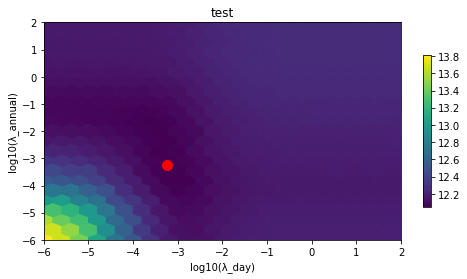

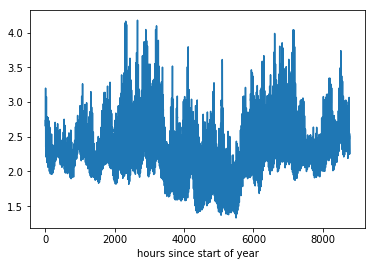

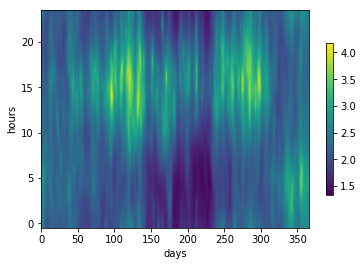

In [37]:
plot_RMSE(res_sq_baseline, res_sq_baseline.val_costs, 'test')
plot_2d_model(np.sqrt(res_sq_baseline.theta))

In [38]:
# #res_baseline.theta = np.sqrt(res_baseline.theta)

# plt.plot(np.sqrt(res_sq_baseline.theta))

# fig = plt.figure()
# cax = plt.imshow(np.sqrt(res_sq_baseline.theta.reshape((366,24))).T, aspect='auto',origin='lower')
# axc = fig.colorbar(cax, ax=fig.gca(), shrink=.7)

### Prediction on sample days 

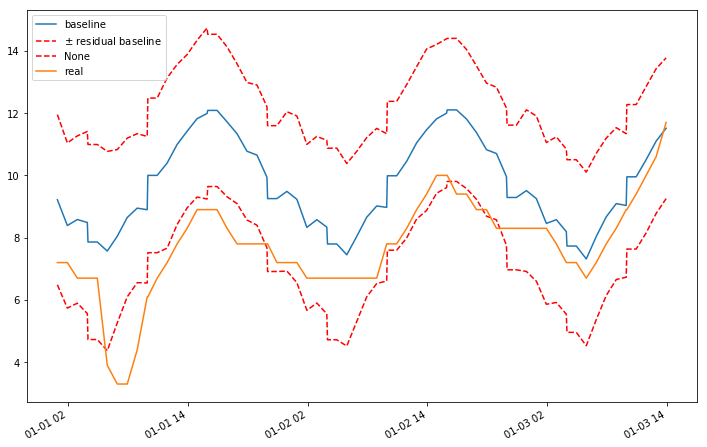

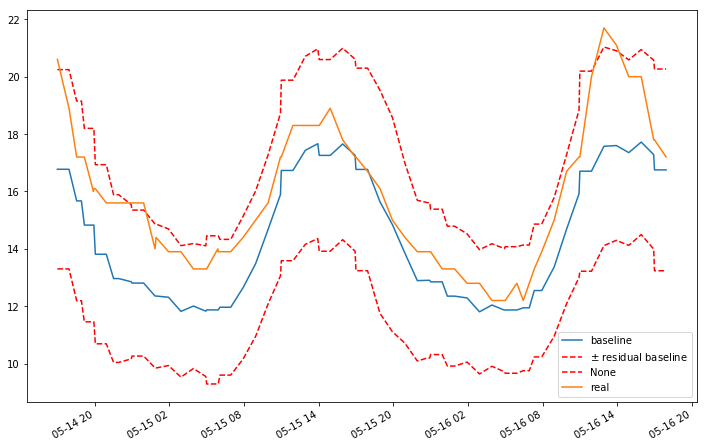

In [54]:
win_data = indep_test[24*0:24*3]

plt.figure(figsize=(12,8))
one_pc_baseline.predict(win_data.index).plot(label='baseline')
(one_pc_baseline.predict(win_data.index) + np.sqrt(res_sq_baseline.predict(win_data.index))).plot(label='$\pm$ residual baseline',
                                                                                 style='r--')
(one_pc_baseline.predict(win_data.index) - np.sqrt(res_sq_baseline.predict(win_data.index))).plot(style='r--')
win_data.plot(label='real')
plt.legend()

win_data = indep_test[24*180:24*183]

plt.figure(figsize=(12,8))
one_pc_baseline.predict(win_data.index).plot(label='baseline')
(one_pc_baseline.predict(win_data.index) + np.sqrt(res_sq_baseline.predict(win_data.index))).plot(label='$\pm$ residual baseline',
                                                                                 style='r--')
(one_pc_baseline.predict(win_data.index) - np.sqrt(res_sq_baseline.predict(win_data.index))).plot(style='r--')
win_data.plot(label='real')
plt.legend()



In [39]:
# residuals = test - baseline.predict(test.index)
# sigmas = np.sqrt(res_sq_baseline.predict(test.index))

# normalized = (residuals/sigmas)

# normalized.kurtosis()

In [40]:
# residuals.hist(bins=400)

In [41]:
# import matplotlib.mlab as mlab

# xs = np.arange(-4,4,.01)

# bins=normalized.hist(bins=400)

# l = plt.plot(xs, mlab.normpdf( xs, 0, 1)*1000, 'r--', linewidth=2)

In [42]:
# residuals.kurtosis()

In [43]:
# xs = np.arange(-10,10,.01)

# bins=residuals.hist(bins=400)

# l = plt.plot(xs, mlab.normpdf( xs, residuals.mean(), residuals.std())*28000, 'r--', linewidth=2)